In [1]:
import numpy as np
import pandas as pd
from mlflow.tracking.client import MlflowClient
from matplotlib import pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from dotenv import load_dotenv

sns.set_style("ticks", {'axes.grid': True})
rcParams['figure.figsize'] = 12, 5
%matplotlib inline

pd.set_option('display.max_rows', 500)

In [2]:
load_dotenv()

client = MlflowClient()

def load_metric(run_id, metric_name, fill_missing=0) -> pd.Series:
    chart = client.get_metric_history(run_id, metric_name)
    steps = [metric.step for metric in chart]
    values = [metric.value for metric in chart]
    return (
        pd.Series(data=values, index=steps, name=metric_name)
        .reindex(range(max(steps) + 1), fill_value=fill_missing)
        .sort_index()
    )

def area(a):
    w = a[:, 2] - a[:, 0]
    h = a[:, 3] - a[:, 1]
    return w * h

def intersect(a, b):
    dx = np.minimum(a[:, 2], b[:, 2]) - np.maximum(a[:, 0], b[:, 0])
    dy = np.minimum(a[:, 3], b[:, 3]) - np.maximum(a[:, 1], b[:, 1])
    return dx * dy * (dx >= 0) * (dy >= 0)

def iou(a, b):
    i = intersect(a, b)
    return i / (area(a) + area(b) - i)

def compare_experiments(id1, id2, fill_missing=0):
    box1_raw_x1 = load_metric(id1, "box_raw_x1", fill_missing)
    box2_raw_x1 = load_metric(id2, "box_raw_x1", fill_missing)
    box1_raw_x2 = load_metric(id1, "box_raw_x2", fill_missing)
    box2_raw_x2 = load_metric(id2, "box_raw_x2", fill_missing)
    box1_raw_y1 = load_metric(id1, "box_raw_y1", fill_missing)
    box2_raw_y1 = load_metric(id2, "box_raw_y1", fill_missing)
    box1_raw_y2 = load_metric(id1, "box_raw_y2", fill_missing)
    box2_raw_y2 = load_metric(id2, "box_raw_y2", fill_missing)
    return (np.abs(box1_raw_x1 - box2_raw_x1).max(),
            np.abs(box1_raw_x2 - box2_raw_x2).max(),
            np.abs(box1_raw_y1 - box2_raw_y1).max(),
            np.abs(box1_raw_y2 - box2_raw_y2).max()
           )

def stat(id1, id2, fill_missing=0):
    m = fill_missing
    box1 = pd.concat([load_metric(id1, "box_crop_x1", m), load_metric(id1, "box_crop_y1", m), 
                      load_metric(id1, "box_crop_x2", m), load_metric(id1, "box_crop_y2", m)
                     ], axis=1)
    box2 = pd.concat([load_metric(id2, "box_crop_x1", m), load_metric(id2, "box_crop_y1", m),
                      load_metric(id2, "box_crop_x2", m), load_metric(id2, "box_crop_y2", m)
                     ], axis=1)
    dist_diff = load_metric(id1, "object_dist_avg", m) - load_metric(id2, "object_dist_avg", m)

    _, ax = plt.subplots(1, 3, figsize=(12, 4))
    sns.scatterplot(dist_diff, ax=ax[0]).set(title="distance diff", ylabel=None)
    sns.histplot(np.abs(dist_diff), ax=ax[1]).set(title="abs distance diff distr", xlabel=None)
    sns.lineplot(iou(box1.values, box2.values), ax=ax[2]).set(title="cropped boxes IoU")

# 1. plane.mp4 (airplane)

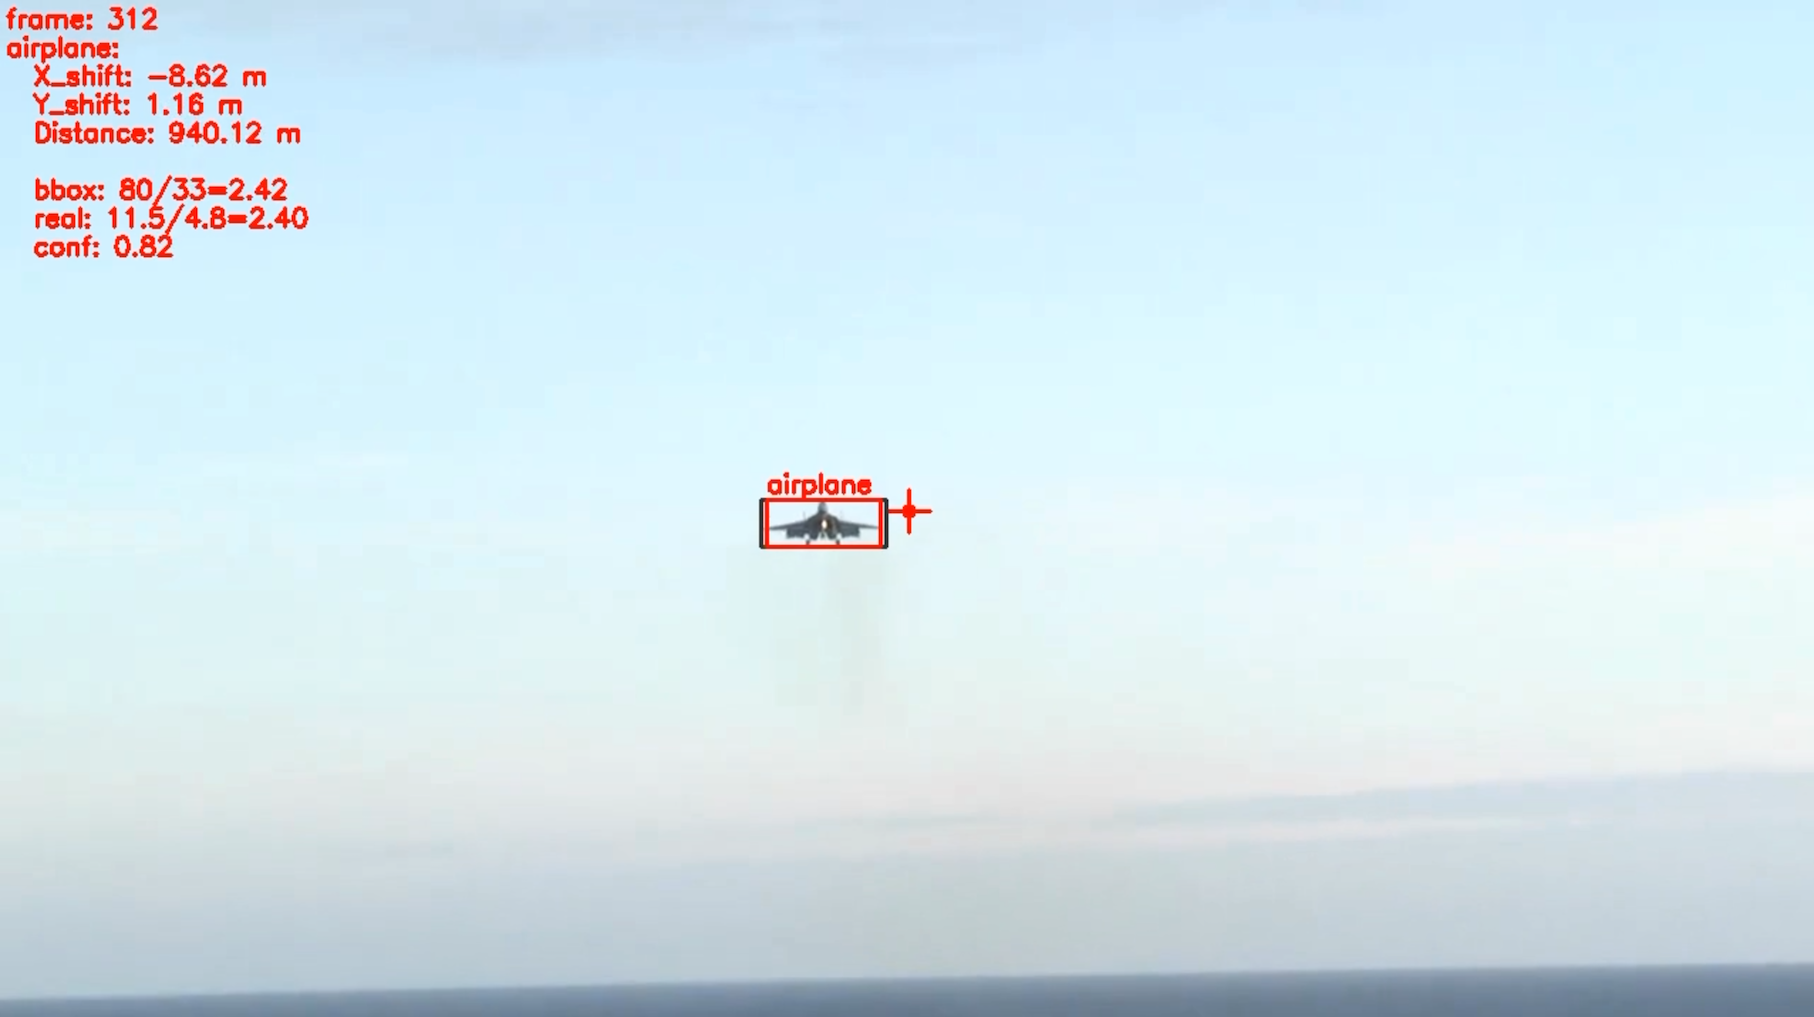

In [3]:
plane_id = "dafae00babb9456984566872c2d97be4"
plane_params = client.get_run(plane_id).data.params
plane_params

{'model': 'yolov8n.pt',
 'conf': '0.2',
 'sample': 'plane.mp4',
 'oname': 'airplane',
 'owidth': '11.5',
 'oheight': '4.8',
 'cfocal': '25.0',
 'cwidth': '4.92',
 'cheight': '2.77',
 'ratiodev': '0.4',
 'smooth': '1.0',
 'async': 'False',
 'video': 'True'}

### смещение объекта от центра

<Axes: ylabel='center_shift_x'>

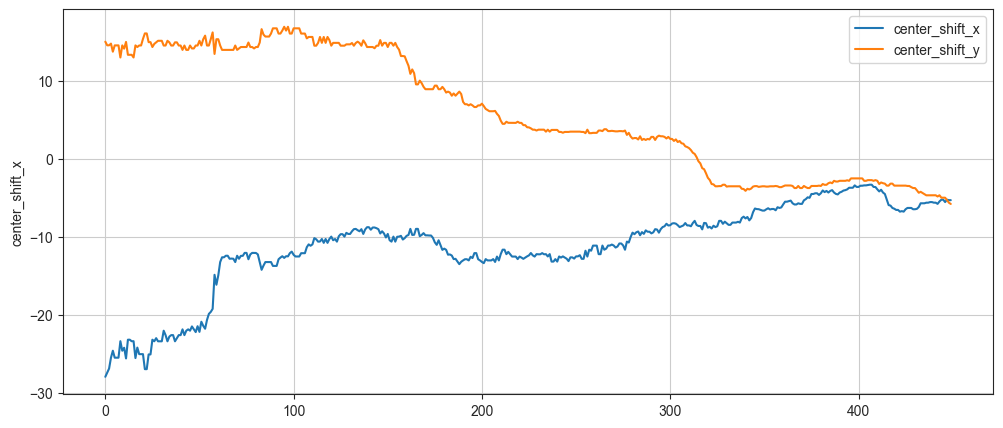

In [4]:
center_shift_x = load_metric(plane_id, "center_shift_x")
center_shift_y = load_metric(plane_id, "center_shift_y")

sns.lineplot(center_shift_x, label="center_shift_x")
sns.lineplot(center_shift_y, label="center_shift_y")

* `center_shift_x` - смещение объекта по горизонтальной оси
* `center_shift_y` - смещение объекта по вертикальной оси

По видео видно, что камера периодически смещается. Резкие изменения на графиках показывают эти моменты

### расстояние до объекта

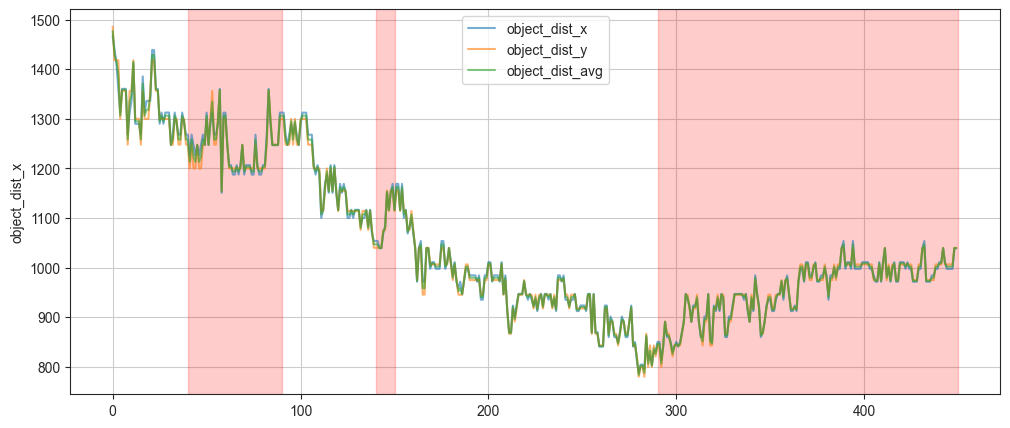

In [5]:
object_dist_x = load_metric(plane_id, "object_dist_x")
object_dist_y = load_metric(plane_id, "object_dist_y")
object_dist_avg = load_metric(plane_id, "object_dist_avg")

sns.lineplot(object_dist_x, alpha=0.6, label="object_dist_x")
sns.lineplot(object_dist_y, alpha=0.6, label="object_dist_y")
sns.lineplot(object_dist_avg, alpha=0.6, label="object_dist_avg")
plt.axvspan(40, 90, alpha=0.2, color='red')
plt.axvspan(140, 150, alpha=0.2, color='red')
plt.axvspan(290, 450, alpha=0.2, color='red')

* `object_dist_x` - расстояние от наблюдателя до проекции центра объекта на горизонтальную ось
* `object_dist_y` - расстояние от наблюдателя до проекции центра объекта на вертикальную ось
* `object_dist_avg` - расстояние от наблюдателя до центра объекта

1. На графике видно, что все 3 расстояния находятся очень близко друг к другу
2. Также на графике есть области (помечены красным), где поведение графика меняется - меняется фокус камеры, так что нельзя достоверно указать расстояние до объекта

### размеры рамки

<Axes: >

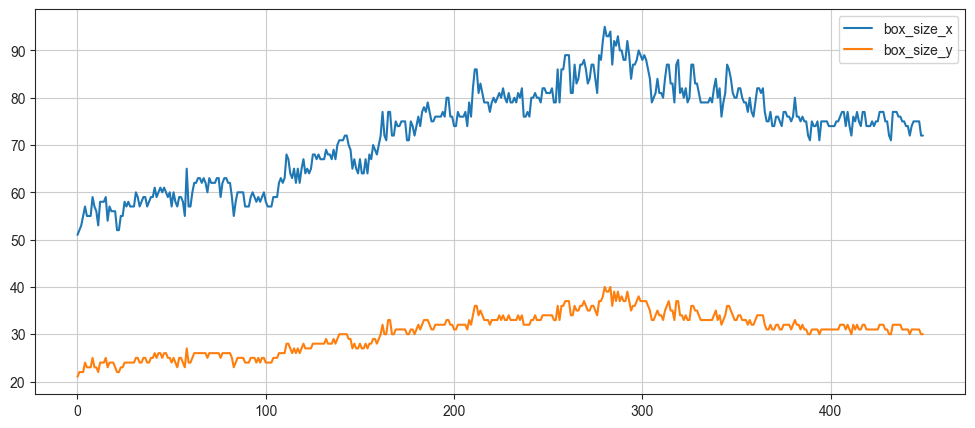

In [6]:
box_x1 = load_metric(plane_id, "box_crop_x1")
box_x2 = load_metric(plane_id, "box_crop_x2")
box_y1 = load_metric(plane_id, "box_crop_y1")
box_y2 = load_metric(plane_id, "box_crop_y2")

sns.lineplot(box_x2 - box_x1, label="box_size_x")
sns.lineplot(box_y2 - box_y1, label="box_size_y")

Размеры рамки постепенно растут - объект приближается до ~300 кадра. Дальше фокусное расстояние камеры начинает уменьшаться

### уверенность детектора в предсказании объекта

<Axes: ylabel='object_conf'>

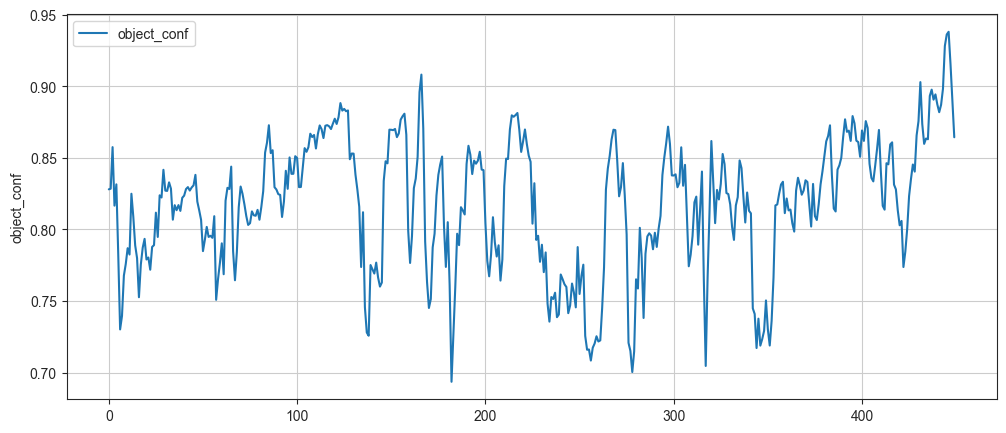

In [7]:
object_conf = load_metric(plane_id, "object_conf")

sns.lineplot(object_conf, label="object_conf")

Уверенность детектора остается на высоком уровне на протяжении всего видео

### сглаживание движения рамки детектора (smooth)

In [8]:
plane_smooth_id = "90487de6a3324a04ae54b3902c92be40"
plane_smooth_params = client.get_run(plane_smooth_id).data.params
plane_smooth_params

{'model': 'yolov8n.pt',
 'conf': '0.2',
 'sample': 'plane.mp4',
 'oname': 'airplane',
 'owidth': '11.5',
 'oheight': '4.8',
 'cfocal': '25.0',
 'cwidth': '4.92',
 'cheight': '2.77',
 'ratiodev': '0.4',
 'smooth': '0.4',
 'async': 'False',
 'video': 'True'}

In [9]:
compare_experiments(plane_id, plane_smooth_id)

(0.0, 0.0, 0.0, 0.0)

Сравненили рамки двух экспериментов. Видно, что используемая модель дает одинаковые результаты 

<Axes: ylabel='object_dist_avg'>

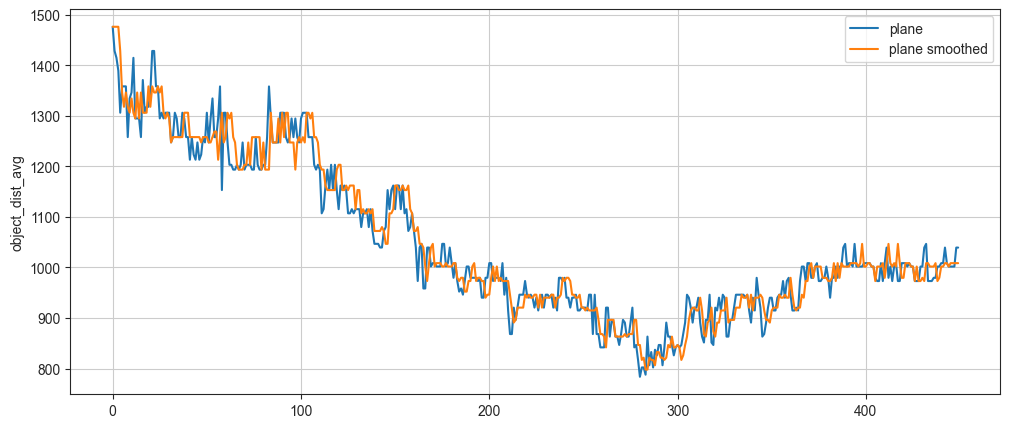

In [10]:
object_dist_avg1 = load_metric(plane_id, "object_dist_avg")
object_dist_avg2 = load_metric(plane_smooth_id, "object_dist_avg")

sns.lineplot(object_dist_avg1, label="plane")
sns.lineplot(object_dist_avg2, label="plane smoothed")

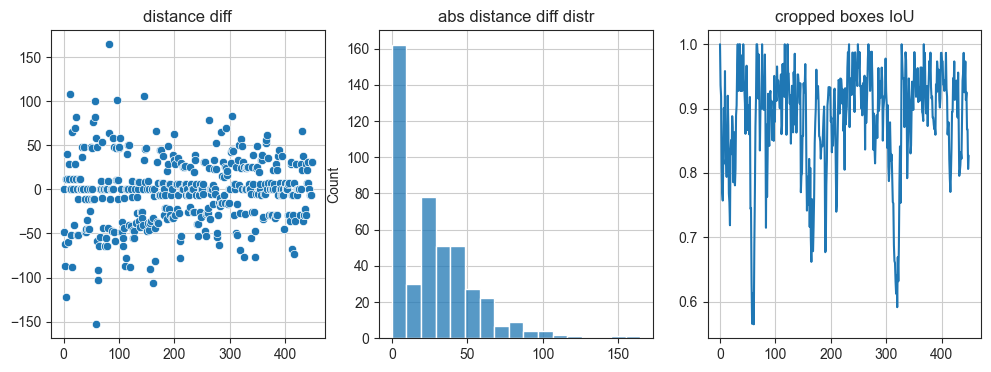

In [11]:
stat(plane_id, plane_smooth_id)

### предсказание движения рамки детектора (async)

In [12]:
plane_async_id = "5203a7c1e4d24cc8a03322743b5ca90e"
plane_async_params = client.get_run(plane_async_id).data.params
plane_async_params

{'model': 'yolov8n.pt',
 'conf': '0.2',
 'sample': 'plane.mp4',
 'oname': 'airplane',
 'owidth': '11.5',
 'oheight': '4.8',
 'cfocal': '25.0',
 'cwidth': '4.92',
 'cheight': '2.77',
 'ratiodev': '0.4',
 'smooth': '1.0',
 'async': 'True',
 'video': 'True'}

<Axes: title={'center': 'distance'}, ylabel='object_dist_avg'>

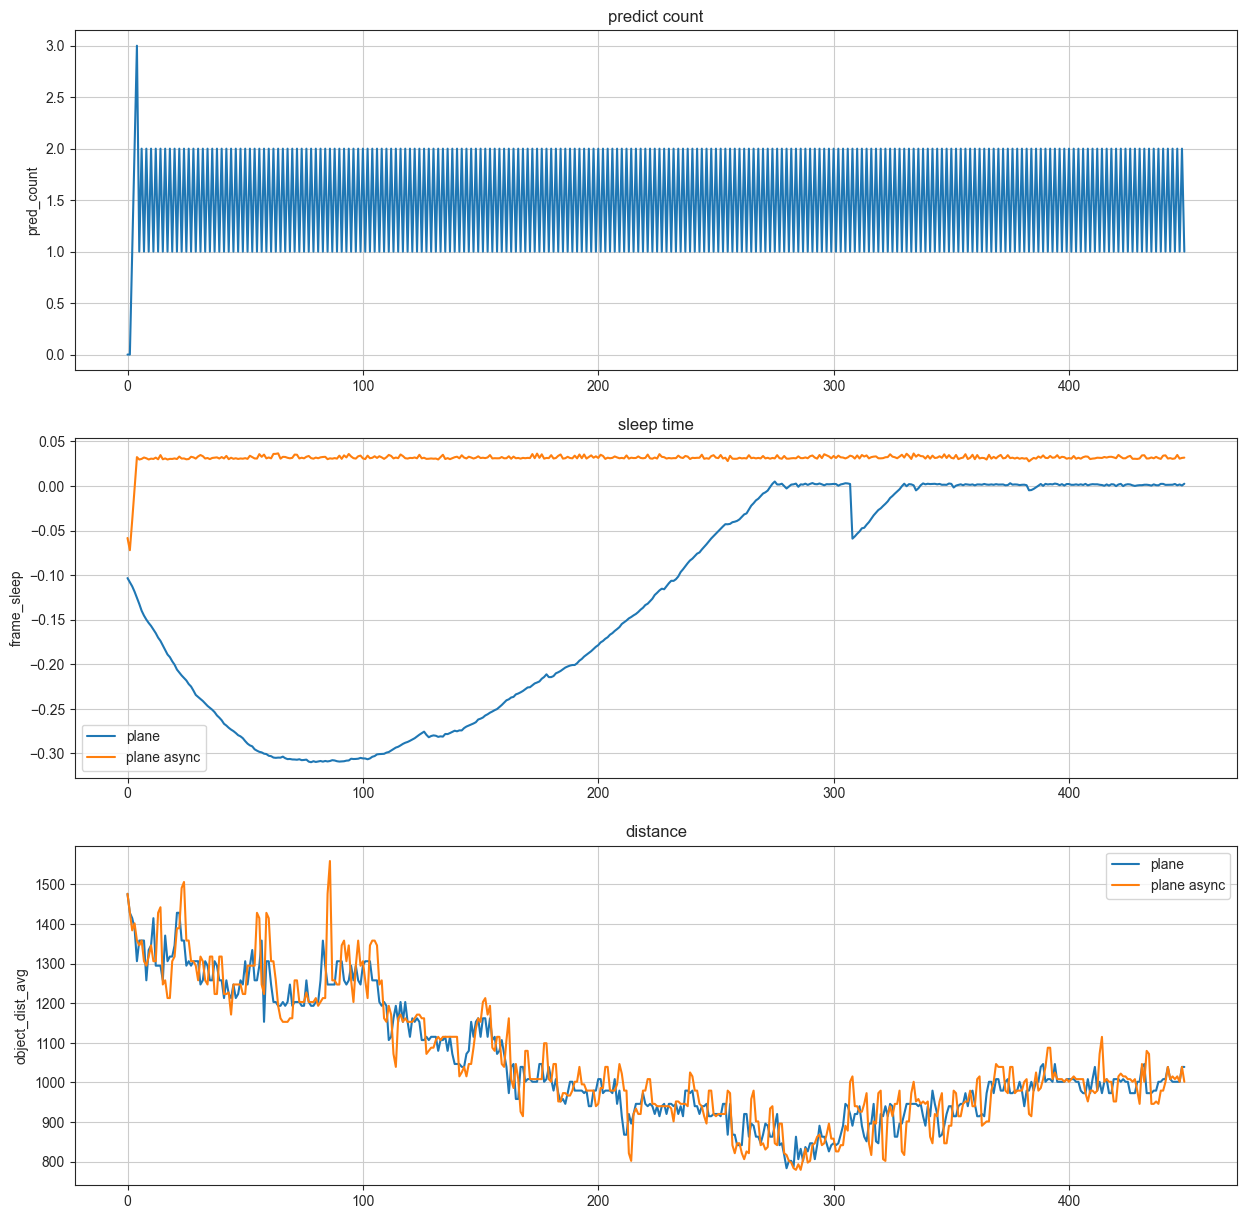

In [13]:
pred_count = load_metric(plane_async_id, "pred_count")
sleep1 = load_metric(plane_id, "frame_sleep")
sleep2 = load_metric(plane_async_id, "frame_sleep")
object_dist_avg1 = load_metric(plane_id, "object_dist_avg")
object_dist_avg2 = load_metric(plane_async_id, "object_dist_avg")

_, ax = plt.subplots(3, 1, figsize=(15, 15))
sns.lineplot(pred_count, ax=ax[0]).set(title="predict count")
sns.lineplot(sleep1, label="plane", ax=ax[1]).set(title="sleep time")
sns.lineplot(sleep2, label="plane async", ax=ax[1])
sns.lineplot(object_dist_avg1, label="plane", ax=ax[2]).set(title="distance")
sns.lineplot(object_dist_avg2, label="plane async", ax=ax[2])

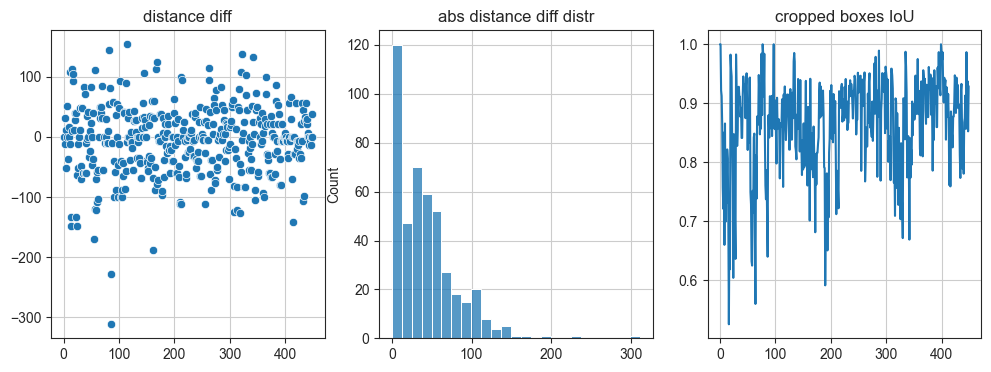

In [14]:
stat(plane_id, plane_async_id)

# 2. fourway.avi (person)

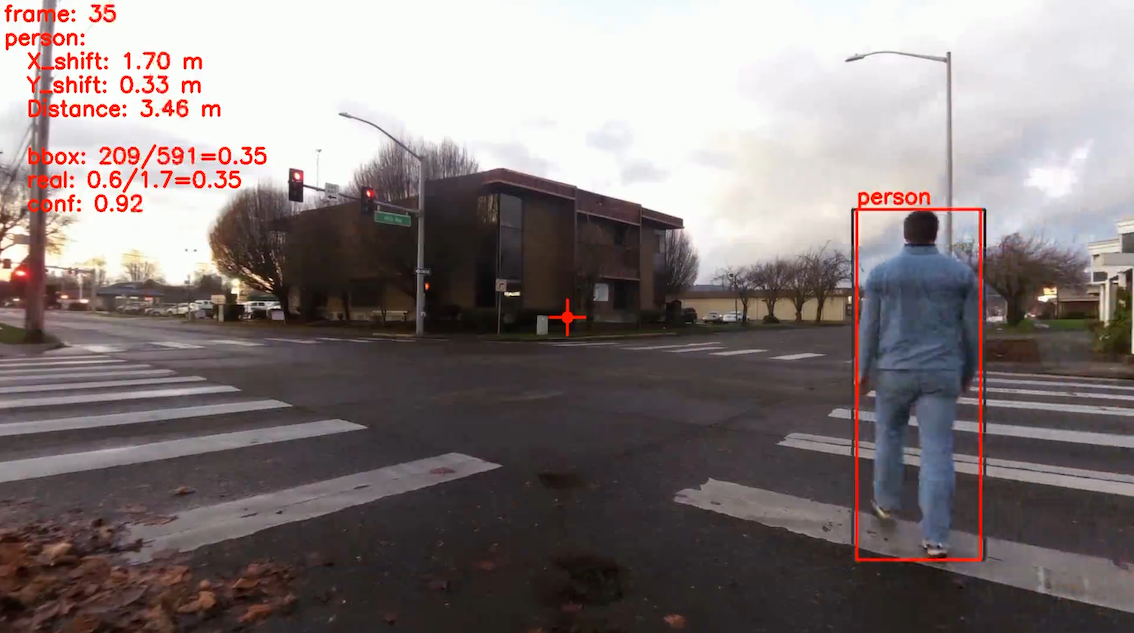

In [15]:
person_id = "6202dc59f05a4ae190aa229554109ae8"
person_params = client.get_run(person_id).data.params
person_params

{'model': 'yolov8n.pt',
 'conf': '0.2',
 'sample': 'fourway.avi',
 'oname': 'person',
 'owidth': '0.6',
 'oheight': '1.7',
 'cfocal': '4.0',
 'cwidth': '7.38',
 'cheight': '4.15',
 'ratiodev': '0.5',
 'smooth': '1.0',
 'async': 'False',
 'video': 'True'}

### смещение объекта от центра

<Axes: ylabel='center_shift_x'>

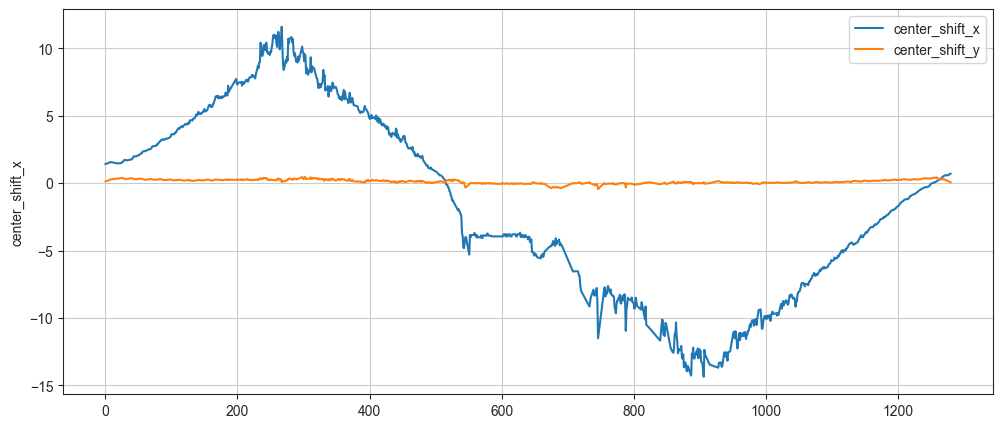

In [16]:
center_shift_x = load_metric(person_id, "center_shift_x", fill_missing=None)
center_shift_y = load_metric(person_id, "center_shift_y", fill_missing=None)

sns.lineplot(center_shift_x, label="center_shift_x")
sns.lineplot(center_shift_y, label="center_shift_y")

* `center_shift_x` - смещение объекта по горизонтальной оси
* `center_shift_y` - смещение объекта по вертикальной оси

Из-за расположения камеры объект смещается только по горизонтальной оси

### расстояние до объекта

<Axes: ylabel='object_dist_x'>

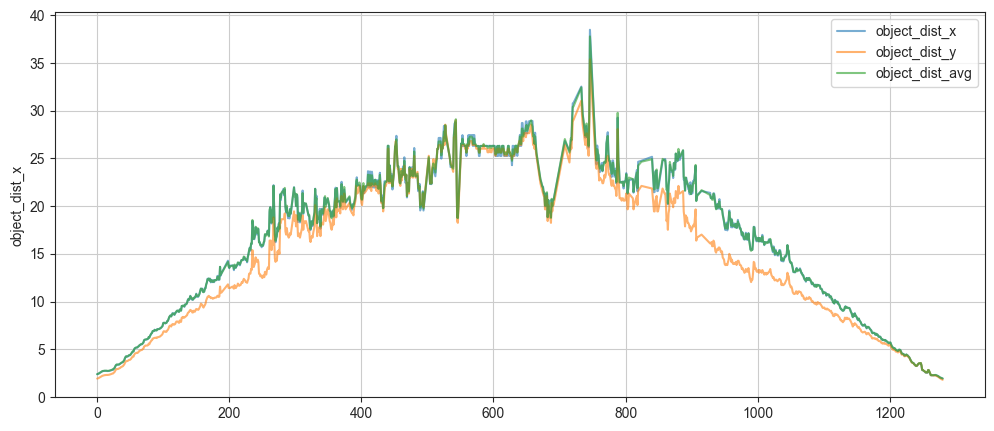

In [17]:
object_dist_x = load_metric(person_id, "object_dist_x", fill_missing=None)
object_dist_y = load_metric(person_id, "object_dist_y", fill_missing=None)
object_dist_avg = load_metric(person_id, "object_dist_avg", fill_missing=None)

sns.lineplot(object_dist_x, alpha=0.6, label="object_dist_x")
sns.lineplot(object_dist_y, alpha=0.6, label="object_dist_y")
sns.lineplot(object_dist_avg, alpha=0.6, label="object_dist_avg")

<Axes: ylabel='center_dist_y'>

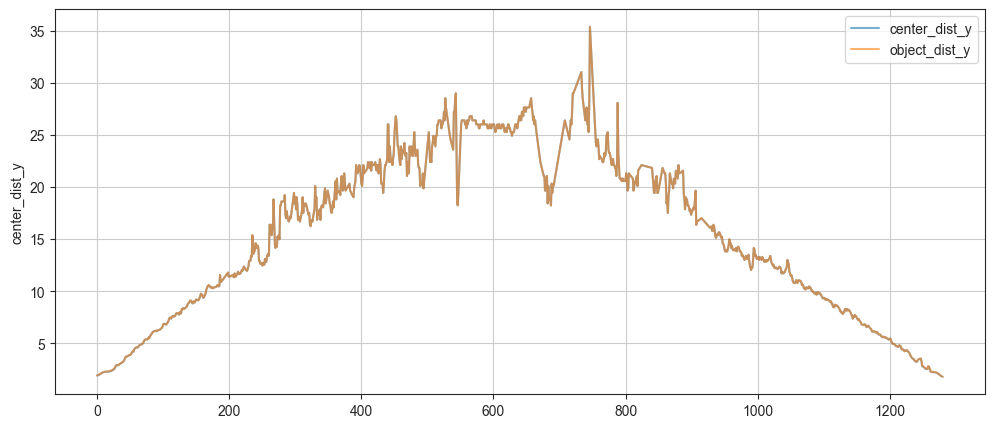

In [18]:
center_dist_y = load_metric(person_id, "center_dist_y", fill_missing=None)

sns.lineplot(center_dist_y, alpha=0.6, label="center_dist_y")
sns.lineplot(object_dist_y, alpha=0.6, label="object_dist_y")

* `object_dist_x` - расстояние от наблюдателя до проекции центра объекта на горизонтальную ось
* `object_dist_y` - расстояние от наблюдателя до проекции центра объекта на вертикальную ось
* `object_dist_avg` - расстояние от наблюдателя до центра объекта
* `center_dist_y` - расстояние от наблюдателя до центра плоскости объекта (по вертикальным размерам пикселей)

Видно, что проекция на вертикальную ось (`object_dist_y`) в некоторых местах сильно отклоняется от расстояния до объекта. Это происходит из-за того, что объект практически не смещается по вертикали, а только по горизонтали. И расстояние `object_dist_y` практически равно расстоянию `center_dist_y`

### размеры рамки

<Axes: >

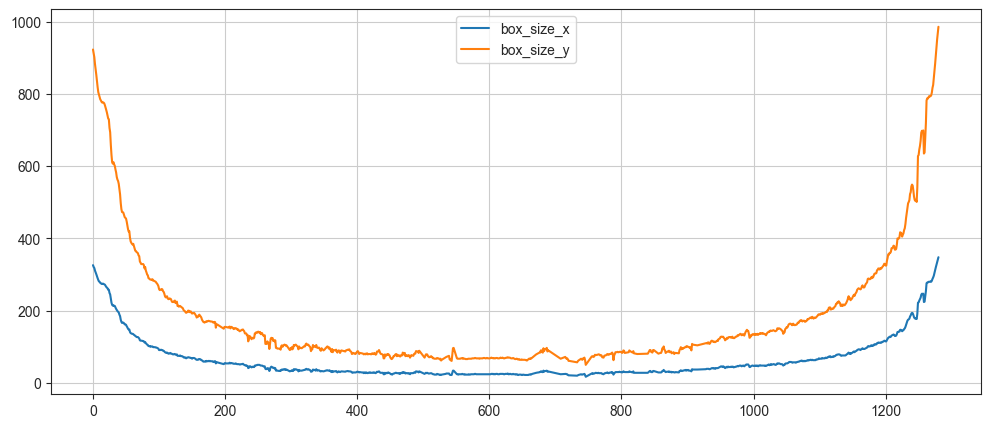

In [19]:
box_x1 = load_metric(person_id, "box_crop_x1", fill_missing=None)
box_x2 = load_metric(person_id, "box_crop_x2", fill_missing=None)
box_y1 = load_metric(person_id, "box_crop_y1", fill_missing=None)
box_y2 = load_metric(person_id, "box_crop_y2", fill_missing=None)

sns.lineplot(box_x2 - box_x1, label="box_size_x")
sns.lineplot(box_y2 - box_y1, label="box_size_y")

Из-за особенностей расположения камеры (на углу перекрестка) размеры объекта уменьшаются быстрее на первой зебре и увеличиваются быстрее на последней зебре

### уверенность детектора в предсказании объекта

<Axes: ylabel='object_conf'>

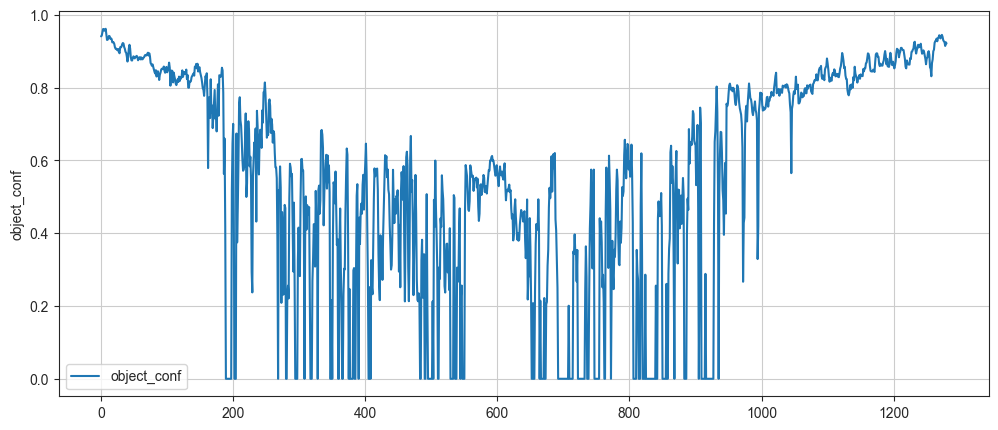

In [20]:
object_conf = load_metric(person_id, "object_conf", fill_missing=0)

sns.lineplot(object_conf, label="object_conf")

<Axes: ylabel='object_conf'>

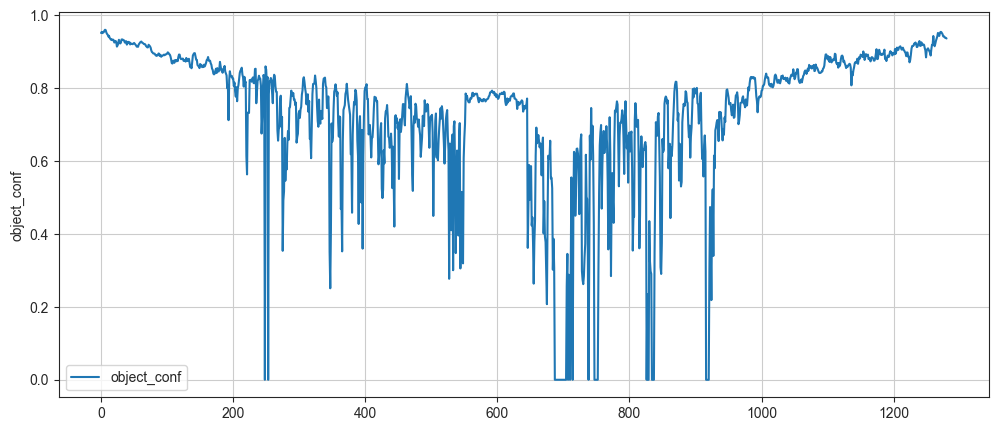

In [21]:
object_conf = load_metric("e4a517299a134663b414cf979b3f7e3b", "object_conf", fill_missing=0)

sns.lineplot(object_conf, label="object_conf")

Видно, что детектору намного сложнее определять объект на большом расстоянии.

На первом графике работа детектора `yolov8n`, а на втором - более сложная модель `yolov8m`. Видно, что более сложная модель более уверена в своих предсказаниях и реже ошибается

### сглаживание движения рамки детектора (smooth)

In [22]:
person_smooth_id = "9e3141247a8c48df83fb034687b4c5b2"
person_smooth_params = client.get_run(person_smooth_id).data.params
person_smooth_params

{'video': 'True',
 'model': 'yolov8n.pt',
 'conf': '0.2',
 'sample': 'fourway.avi',
 'oname': 'person',
 'owidth': '0.6',
 'oheight': '1.7',
 'cfocal': '4.0',
 'cwidth': '7.38',
 'cheight': '4.15',
 'ratiodev': '0.5',
 'smooth': '0.4',
 'async': 'False'}

In [23]:
print("missing=None:", compare_experiments(person_id, person_smooth_id, fill_missing=None))
print("missing=0:", compare_experiments(person_id, person_smooth_id, fill_missing=0))

missing=None: (4.4739990234375, 20.1793212890625, 3.752288818359375, 2.5379638671875)
missing=0: (295.3528747558594, 354.20928955078125, 503.8810729980469, 586.96435546875)


1. координаты рамок двух экспериментов незначительно отличаются.
2. детектор в одном эксперименте может определить рамку, а в другом - нет
3. далее будем пропущенные значения в метриках устанавливать в `None`

<Axes: ylabel='object_dist_avg'>

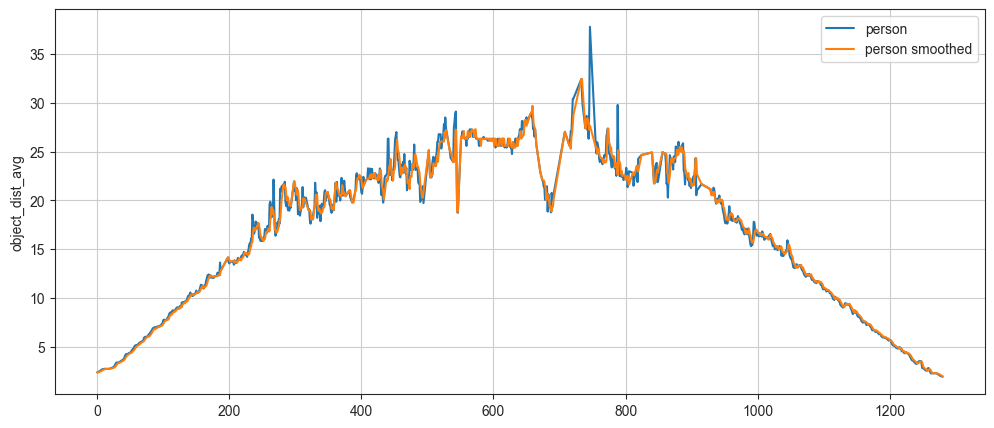

In [24]:
object_dist_avg1 = load_metric(person_id, "object_dist_avg", fill_missing=None)
object_dist_avg2 = load_metric(person_smooth_id, "object_dist_avg", fill_missing=None)

sns.lineplot(object_dist_avg1, label="person")
sns.lineplot(object_dist_avg2, label="person smoothed")

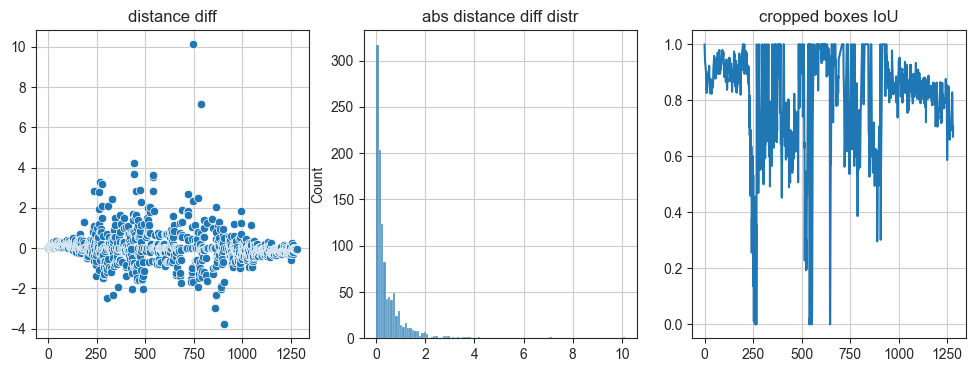

In [25]:
stat(person_id, person_smooth_id, fill_missing=None)

### предсказание движения рамки детектора (async)

In [26]:
person_async_id = "d3ab7a95e9ed447ca244915ea82b6e27"
person_async_params = client.get_run(person_async_id).data.params
person_async_params

{'model': 'yolov8n.pt',
 'conf': '0.2',
 'sample': 'fourway.avi',
 'oname': 'person',
 'owidth': '0.6',
 'oheight': '1.7',
 'cfocal': '4.0',
 'cwidth': '7.38',
 'cheight': '4.15',
 'ratiodev': '0.5',
 'smooth': '1.0',
 'async': 'True',
 'video': 'True'}

<Axes: title={'center': 'distance'}, ylabel='object_dist_avg'>

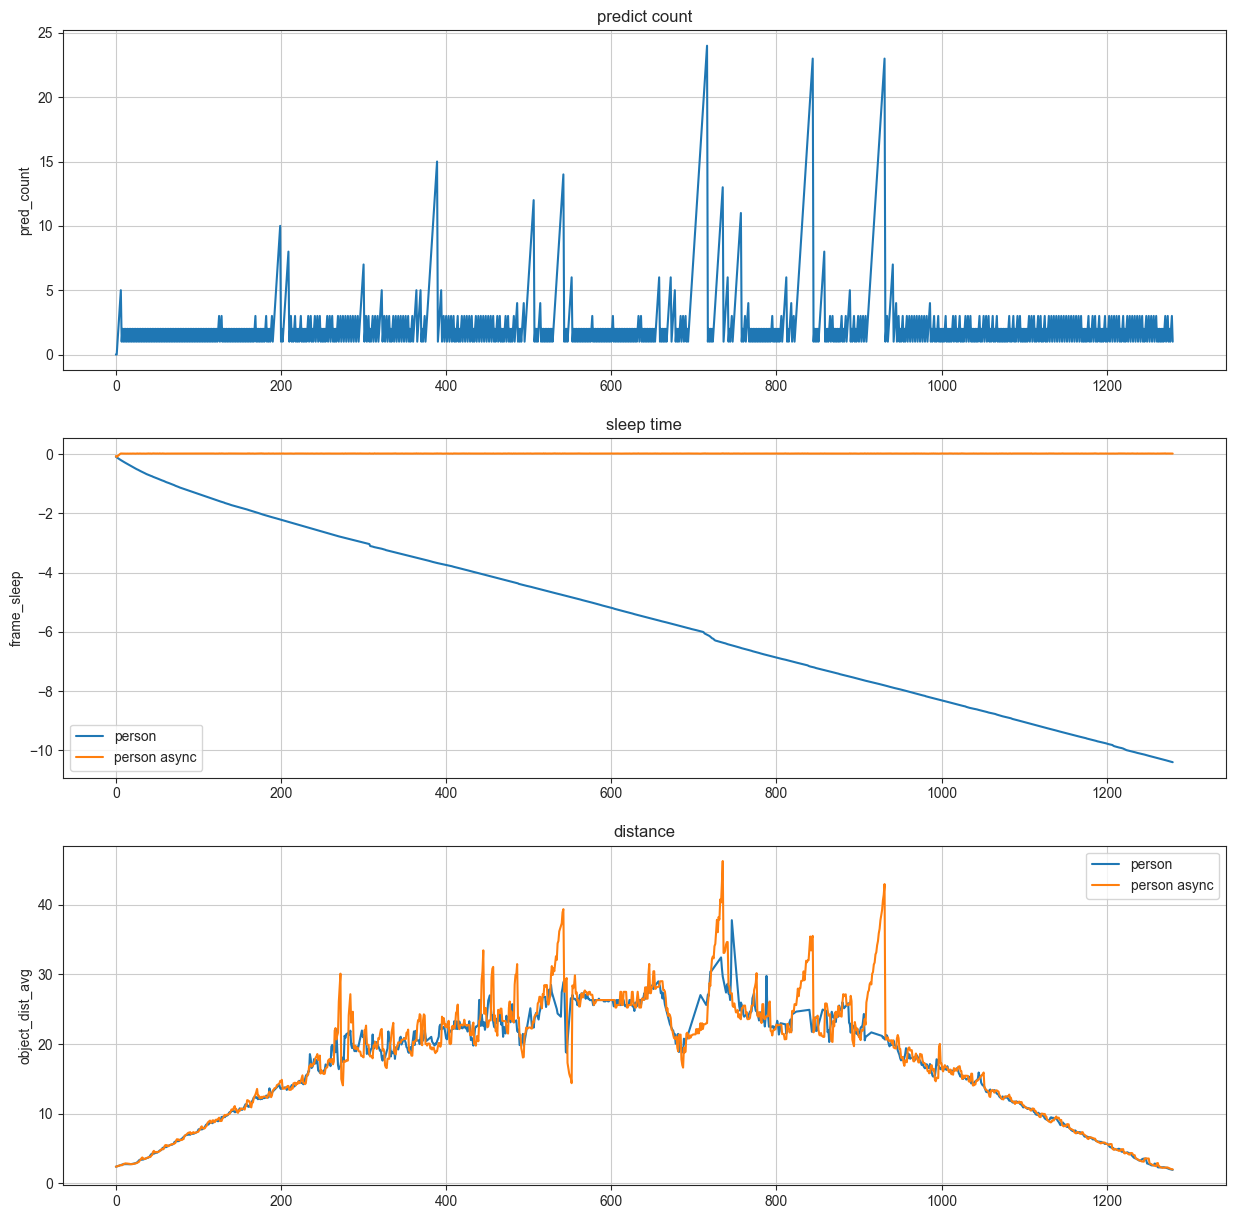

In [27]:
pred_count = load_metric(person_async_id, "pred_count")
sleep1 = load_metric(person_id, "frame_sleep")
sleep2 = load_metric(person_async_id, "frame_sleep")
object_dist_avg1 = load_metric(person_id, "object_dist_avg", fill_missing=None)
object_dist_avg2 = load_metric(person_async_id, "object_dist_avg")

_, ax = plt.subplots(3, 1, figsize=(15, 15))
sns.lineplot(pred_count, ax=ax[0]).set(title="predict count")
sns.lineplot(sleep1, label="person", ax=ax[1]).set(title="sleep time")
sns.lineplot(sleep2, label="person async", ax=ax[1])
sns.lineplot(object_dist_avg1, label="person", ax=ax[2]).set(title="distance")
sns.lineplot(object_dist_avg2, label="person async", ax=ax[2])

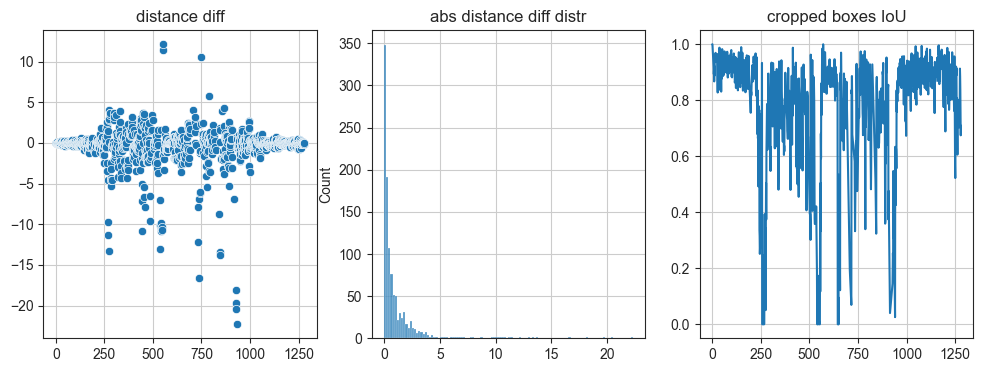

In [28]:
stat(person_id, person_async_id, fill_missing=None)